In [142]:
%autosave 30

Autosaving every 30 seconds


# Введение

Мы решили открыть небольшое кафе в Москве. Гостей должны обслуживать роботы. Инвесторов интересует текущее положение дел на рынке — сможем ли мы быть популярным заведением долгое время, когда клиенты насмотрятся на роботов-официантов?
Необходимо подготовить исследование рынка.  Нужно подготовить общий вывод и дайть рекомендации о виде заведения, количестве посадочных мест, а также районе расположения. Сделать выводы о возможности развития сети.

# 1. Загрузка данных и подготовьте их к анализу

In [143]:
# Импортируем нужные нам библиотеки 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from io import BytesIO
import requests
import numpy as np
import seaborn as sns 

Прочитаем данные. Сначала ознакомимся с таблицей.

In [144]:
spreadsheet_id = '1o2fHkqX_-AOJ5MKeV7UDm3PVJQo5BZpDZbt_hYKnfC4'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
data = pd.read_csv(BytesIO(r.content))
data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [145]:
def data_info(data): 
    data.head()
    data.columns = [x.lower().replace(' ', '_') for x in data.columns]
    data.describe()
    print(data.info()), print(''),  print( data.describe()), print(''), print('Кол-во дубликатов'), print(data.duplicated().sum())
data_info(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB
None

            id  number
count 15366.0  15366.0
mean  119720.1 59.5   
std   73036.1  74.7   
min   838.0    0.0    
25%   28524.0  12.0   
50%   144974.5 40.0   
75%   184262.2 80.0   
max   223439.0 1700.0 

Кол-во дубликатов
0


In [146]:
dubble = data.duplicated(subset=['object_name', 
'chain',        
'object_type',
'address', 
'number']).reset_index()
dubble= dubble[dubble[0]==True]
dubble.count()

index    82
0        82
dtype: int64

Мы видим 82 дубликата. Удалим их. 

In [147]:
data=data.drop_duplicates(subset=['object_name', 
'chain',        
'object_type',
'address', 
'number'], keep='first')

In [148]:
dubble =data.duplicated(subset=['object_name', 
'chain',        
'object_type',
'address', 
'number']).reset_index()
dubble= dubble[dubble[0]==True]
dubble.count()

index    0
0        0
dtype: int64

Избавились от дубликатов. 

Я написала функцию для быстрого анализа дынных. info, describe, а также преобразовала все заголовкаи столбцов к нижнему регистру.

Мы видим, что полных дублекатов у нас нет. Единственное, можно привести id к типу object. 

In [149]:
data['id'] = str(data['id'])

In [150]:
data.info() #Убедились, что поменялось.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15284 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15284 non-null  object
 1   object_name  15284 non-null  object
 2   chain        15284 non-null  object
 3   object_type  15284 non-null  object
 4   address      15284 non-null  object
 5   number       15284 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 835.8+ KB


Импортируем из внешнего истоячника данных таблицу, с районами Москвы. Это в дальнейшем понадобится нам для анализа. 

In [151]:
spreadsheet_id = '1o0Rmxii5snYG8fk0Q81p9D5F9bZyslSPOGci7lpQ1Po'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df_district = pd.read_csv(BytesIO(r.content))
df_district.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17.0,ЦАО,Пресненский район
1,улица Гашека,17.0,ЦАО,Пресненский район
2,Большая Никитская улица,17.0,ЦАО,Пресненский район
3,Глубокий переулок,17.0,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17.0,ЦАО,Пресненский район


In [152]:
data_info(df_district)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4432 entries, 0 to 4431
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   streetname  4432 non-null   object 
 1   areaid      4397 non-null   float64
 2   okrug       4431 non-null   object 
 3   area        4431 non-null   object 
dtypes: float64(1), object(3)
memory usage: 138.6+ KB
None

       areaid
count 4397.0 
mean  59.2   
std   38.5   
min   12.0   
25%   20.0   
50%   51.0   
75%   93.0   
max   134.0  

Кол-во дубликатов
8


# 2. Исследовательский анализ данных

##  Виды объектов

Исследуем соотношение видов объектов общественного питания по количеству.

In [153]:
d_grouped = data.groupby(['object_type'])['id'].count()
d_grouped = d_grouped.reset_index().sort_values(by = 'id', ascending=False)
print(d_grouped)
labels = d_grouped['object_type']
values = d_grouped['id']
fig = go.Figure(data=[go.Bar(x = labels, y = values)])
fig.update_layout(
                  title="Колличество точек по типу предприятия",
                  xaxis_title="Тип предприятия",
                  yaxis_title="Кол-во точек")
fig.show()

                         object_type    id
3  кафе                               6071
8  столовая                           2584
7  ресторан                           2282
6  предприятие быстрого обслуживания  1898
0  бар                                855 
1  буфет                              577 
4  кафетерий                          395 
2  закусочная                         349 
5  магазин (отдел кулинарии)          273 


По этому графику мы можем сделать вывод, что больше всего в Москве кафе. На втором месте столовые, на третьем рестораны. 

In [154]:
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(
    title_text='Распределение долей по типу предприятия',
    title_font_size=20)
fig.show()


Тут мы видим доли.  39,7% это кафе, столовых 16,8% от всех видов предприятия. Ресторанов 14,9%.

## Сети и единичные предприятия 

Исследуем соотношение сетевых и несетевых заведений по количеству.

In [155]:
data_grouped = data.groupby(['chain'])['id'].count()
data_grouped = data_grouped.reset_index().sort_values(by = 'id', ascending=False)
print(data_grouped)
labels = data_grouped['chain']
values = data_grouped['id']


  chain     id
1  нет   12320
0  да    2964 


In [156]:
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(
    title_text='Распределение долей по типу предприятия',
    title_font_size=20)
fig.show()

Интересные выводы получаются. Оказывается, что сети составляют всего 19,3%. А больше всего одиночных предприятий.

Посмотрим для какого вида объекта общественного питания характерно сетевое распространение.

In [157]:
data_chain= data[data['chain']=='да']
data_alone = data[data['chain']=='нет']

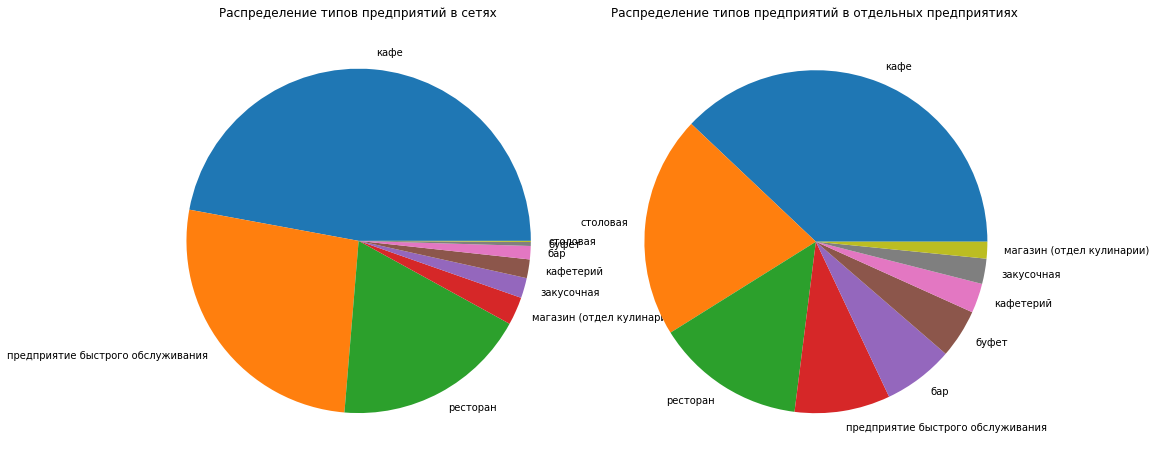

In [158]:
d_grouped_chain = data_chain.groupby(['object_type'])['id'].count()
d_grouped_chain = d_grouped_chain.reset_index().sort_values(by = 'id', ascending=False)
vals_chain = d_grouped_chain['id'].values
labels_chain = d_grouped_chain['object_type']
fig = plt.figure(figsize=(15, 8))
ax = fig.subplots(1, 2)
ax[0].pie(vals_chain, labels=labels_chain)
ax[0].axis("equal")
ax[0].set_title('Распределение типов предприятий в сетях');

d_grouped_alone = data_alone.groupby(['object_type'])['id'].count()
d_grouped_alone = d_grouped_alone.reset_index().sort_values(by = 'id', ascending=False)
labels_alone = d_grouped_alone['object_type']
values_alone = d_grouped_alone['id'].values
#ax = plt.subplots()
ax[1].pie(values_alone, labels=labels_alone)
ax[1].axis("equal")
ax[1].set_title('Распределение типов предприятий в отдельных предприятиях');

In [159]:
chain_grouped = data.pivot_table(index=['chain','object_type' ], values="id", aggfunc='count')
chain_grouped = chain_grouped.reset_index()
tmp1 = chain_grouped.groupby(['chain','object_type'])[['id']].sum()
tmp1 = tmp1.reset_index()
tmp2 = chain_grouped.groupby(['object_type'])['id'].sum()
tmp2 = tmp2.reset_index()
tmp1 = tmp1.merge(tmp2, on = 'object_type', how='inner')
tmp1['ratio'] = tmp1['id_x'] / tmp1['id_y']*100

In [160]:
gf = px.data.medals_long()

fig = px.bar(tmp1, x="object_type", y="ratio", color="chain", text="chain")

fig.show()

Мы видим, что сетевое распределение больше всего характерно для предприятий быстрого обслуживания. А для столовых, наоборот, характерно единичные предприятия.Также доля кафе в сетях выше, чем в отдельных предприятиях.  

## Посадочые места

Постотрим как распределяются посадочные места по типу заведений. 

In [161]:
print(data.describe());
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.1f}'.format)

       number
count 15284.0
mean  59.8   
std   74.8   
min   0.0    
25%   14.0   
50%   40.0   
75%   80.0   
max   1700.0 


Мы видим, что медиана посадочных мест 40, а среднее намного больше 74. Построим гистограмму распределения посадочных мест. 

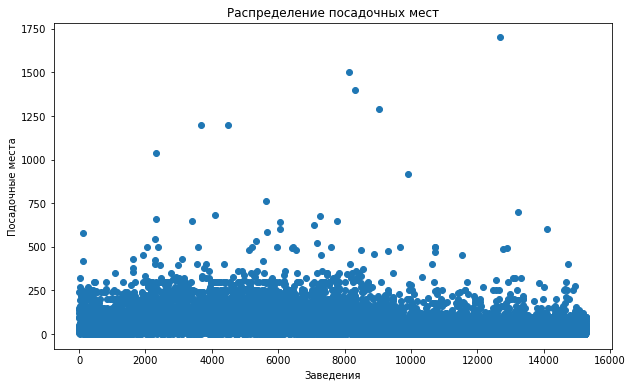

In [162]:
fig, ax = plt.subplots(figsize=(10, 6))
x_values = pd.Series(range(0, len(data['id'])))
ax.scatter(x_values, data['number'])
ax.set_xlabel('Заведения')
ax.set_ylabel('Посадочные места')
plt.title('Распределение посадочных мест')
plt.show()

Мы видим, что есть выбросы в данных. И они достаточны существенны. Есть заведения с 1700 посадочных мест. Однако таких не много. Думаю мы можем ограничиться 400 посадочными местами. 

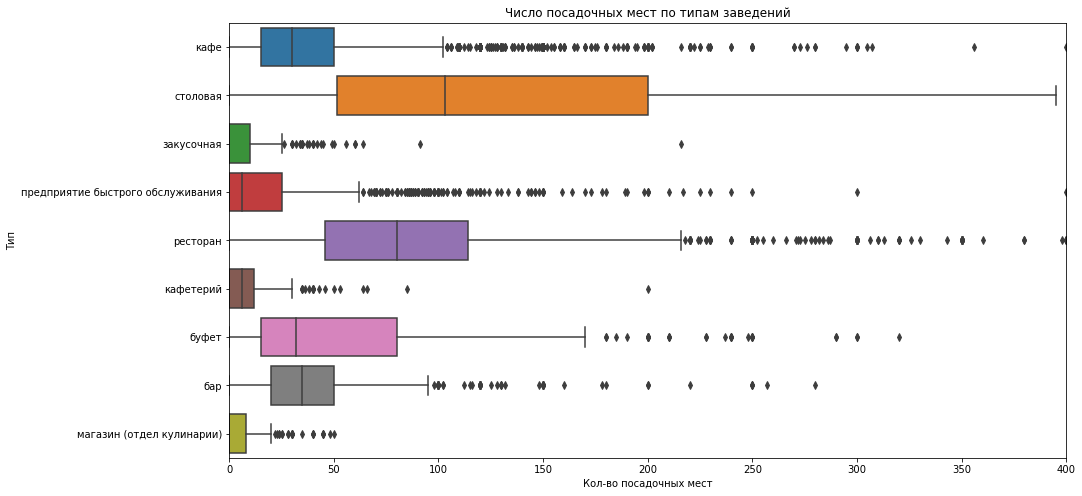

In [163]:


plt.figure(figsize=(15, 8))
sns.boxplot(data=data, y = 'object_type', x = 'number')
plt.title('Число посадочных мест по типам заведений')
plt.ylabel('Тип')
plt.xlabel('Кол-во посадочных мест')
plt.xlim([0,400])
plt.show()

Мы видим, что среднее кол-во посадочных мест самое большое у столовых. Медиана тоже у них выше. Однако у ресторанов и кафе много выбросов. Это значит, что у них сильно разнятся кол-во посадочных мест. Есть кафе и рестораны с очень большим кол-ом посадочных мест, однако в большиенстве заведений кол-во посадочных мест меньше 100. 

Опишем для каждого вида объекта общественного питания среднее количество посадочных мест.

In [164]:
place_grouped = data.groupby(['object_type'])['number'].mean()
place_grouped = place_grouped.reset_index().sort_values(by = 'number', ascending=False)
print(place_grouped)

                         object_type  number
8                           столовая   130.3
7                           ресторан    96.9
1                              буфет    51.5
0                                бар    43.5
3                               кафе    39.8
6  предприятие быстрого обслуживания    20.8
4                          кафетерий     9.2
2                         закусочная     7.8
5          магазин (отдел кулинарии)     5.6


In [165]:
labels = place_grouped['object_type']
values = place_grouped['number']
fig = go.Figure(data=[go.Bar(x = labels, y = values)])
fig.update_layout(
                  title="Среднее кол-во посадочных мест по типу предприятия",
                  xaxis_title="Тип предприятия",
                  yaxis_title="Кол-во посадочных мест")
fig.show()

Мы видим, что самое большое  среднее кол-во посадочных мест у столовых. На втором месте рестораны, за ним буфеты. Меньше всего у магазинов (что не удивительно)

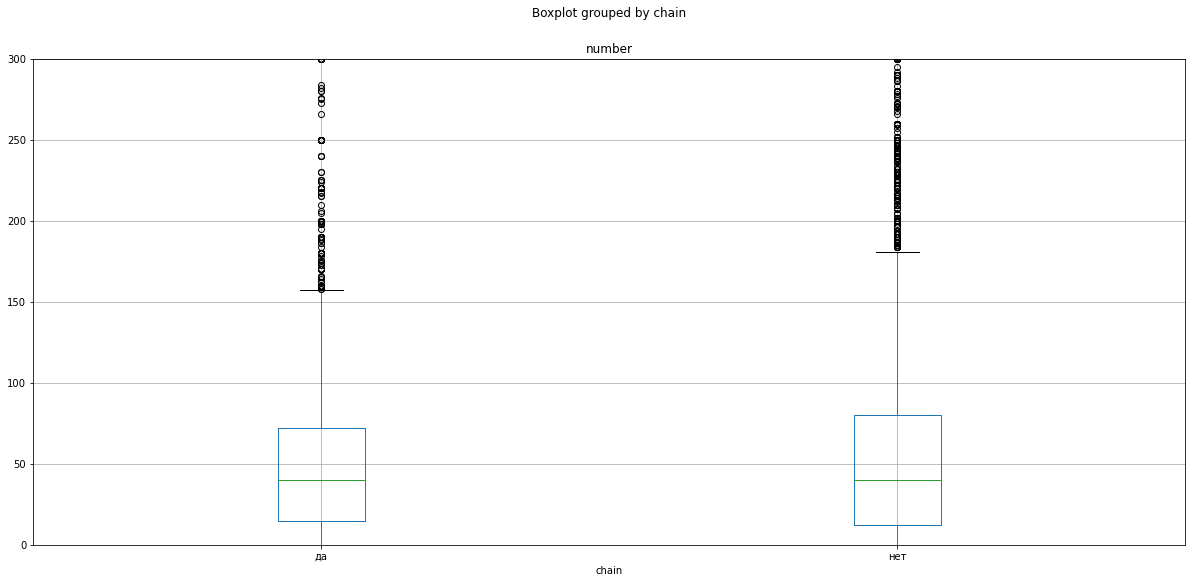

In [166]:

data.boxplot(by = 'chain', column = 'number', figsize = (20,9))
plt.ylim([0,300])
plt.show()

Мы видим, что для сетевых заведений характерно много заведений с небольшим числом посадочных мест в каждом.

In [167]:
chain_df = data.query('chain == "да"')
chain_df_new = (chain_df.groupby('object_name')
               .agg({'id':'count', 'number':'mean'})
               .reset_index()
               .rename(columns={'id':'кол-во заведений', 'number':'среднее кол-во мест'})
               .sort_values(by='кол-во заведений', ascending=False)   
               )
chain_df_new.head()

,object_name,кол-во заведений,среднее кол-во мест
30,KFC,155,55.3
702,Шоколадница,141,56.2
127,Бургер Кинг,122,45.0
418,Макдоналдс,121,82.2
195,Домино'с Пицца,86,18.2


Создадим таблицу, сгруппируя по названию заведений. Добавим кол-во заведений, тем самым мы получим сколько заведений приходится на 1 сеть. И среднее кол-во мест. 

In [168]:
print('90 кол-во заведений', np.percentile(chain_df_new['кол-во заведений'], [90]))
print('90 Среднее кол-во посадочных мест', np.percentile(chain_df_new['среднее кол-во мест'], [90]))

90 кол-во заведений [6.]
90 Среднее кол-во посадочных мест [134.4]


Посчитали 90 пресентиль. Получилось, что у большинства сетей не более 6 заведений и 134 посадочных мест в каждом ресторане в среднем. 

Напишем функцию, которая делит все заведения на 4 типа. 

In [169]:
def number_chain (i):
    total = i['кол-во заведений']
    mean=i['среднее кол-во мест']
    if total >= 6: 
        if mean >= 130:
            return 'много заведений/много мест'
    if total >= 6:
        if mean <= 130:
            return 'много заведений/мало мест'
    if total <= 6:
        if mean >= 130:
            return 'мало заведений/много мест'
    if total <= 6:
        if mean <= 130:
            return 'мало заведений/мало мест'
chain_df_new['category'] = chain_df_new.apply(number_chain, axis = 1)

In [170]:
pd.options.display.max_colwidth = 1
chain_df_new

,object_name,кол-во заведений,среднее кол-во мест,category
30,KFC,155,55.3,много заведений/мало мест
702,Шоколадница,141,56.2,много заведений/мало мест
127,Бургер Кинг,122,45.0,много заведений/мало мест
418,Макдоналдс,121,82.2,много заведений/мало мест
195,Домино'с Пицца,86,18.2,много заведений/мало мест
...,...,...,...,...
293,Кафе «Марукамэ»,1,40.0,мало заведений/мало мест
291,Кафе «МЕЛЕНКА»,1,60.0,мало заведений/мало мест
290,Кафе «МАКДОНАЛДС»,1,40.0,мало заведений/мало мест
289,Кафе «Кулинарное бюро»,1,18.0,мало заведений/мало мест


In [171]:
fig = px.scatter(chain_df_new, x = 'кол-во заведений', y = 'среднее кол-во мест', color = 'category',
                 render_mode="webgl", width=1000, height=600,  
                 title = 'Соотношение количества посадочных мест и количества точек в сети')
 
fig.show()

Мы видим, что для большинства сетевых предприятий характерно мало заведений с маленьким кол-ом мест. 

## Анализ улиц

Выделите в отдельный столбец информацию об улице из столбца address

In [172]:

def street(address):
    sep = address.split(', ')
    for i in sep:
        if i != 'город Зеленоград' and i != 'поселение Сосенское':
            result = sep[1]
        else:
            return 'unknown'
    return result
def street(row):
    address = row['address']
    name_street =[]
    list_street = ['улица', 'бульвар', 'шоссе', 'переулок', 'проспект', 'проезд', 'площадь', 'набережная']
    for n in row['address'].split(sep=', '):
        for word in list_street:
            if word in n:
                name_street.append(n)
    return ', '.join(name_street)

data['street_name'] = data.apply(street, axis = 1) 

In [173]:
data.head()

,id,object_name,chain,object_type,address,number,street_name
0,"0 151635\n1 77874 \n2 24309 \n3 21894 \n4 119365\n ... \n15361 208537\n15362 209264\n15363 209186\n15364 221900\n15365 222535\nName: id, Length: 15284, dtype: int64",СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,"0 151635\n1 77874 \n2 24309 \n3 21894 \n4 119365\n ... \n15361 208537\n15362 209264\n15363 209186\n15364 221900\n15365 222535\nName: id, Length: 15284, dtype: int64",Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,"0 151635\n1 77874 \n2 24309 \n3 21894 \n4 119365\n ... \n15361 208537\n15362 209264\n15363 209186\n15364 221900\n15365 222535\nName: id, Length: 15284, dtype: int64",Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,"0 151635\n1 77874 \n2 24309 \n3 21894 \n4 119365\n ... \n15361 208537\n15362 209264\n15363 209186\n15364 221900\n15365 222535\nName: id, Length: 15284, dtype: int64",ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,"0 151635\n1 77874 \n2 24309 \n3 21894 \n4 119365\n ... \n15361 208537\n15362 209264\n15363 209186\n15364 221900\n15365 222535\nName: id, Length: 15284, dtype: int64",Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


In [174]:

data.groupby('street_name').agg({'id':'count'}).sort_values(by='id', ascending=False).reset_index()

,street_name,id
0,,464
1,проспект Мира,204
2,Профсоюзная улица,182
3,Ленинградский проспект,172
4,Пресненская набережная,167
...,...,...
1866,улица Академика Семёнова,1
1867,1-й Монетчиковский переулок,1
1868,2-я Дубровская улица,1
1869,2-я Гражданская улица,1


In [175]:
data.head()

,id,object_name,chain,object_type,address,number,street_name
0,"0 151635\n1 77874 \n2 24309 \n3 21894 \n4 119365\n ... \n15361 208537\n15362 209264\n15363 209186\n15364 221900\n15365 222535\nName: id, Length: 15284, dtype: int64",СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,"0 151635\n1 77874 \n2 24309 \n3 21894 \n4 119365\n ... \n15361 208537\n15362 209264\n15363 209186\n15364 221900\n15365 222535\nName: id, Length: 15284, dtype: int64",Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,"0 151635\n1 77874 \n2 24309 \n3 21894 \n4 119365\n ... \n15361 208537\n15362 209264\n15363 209186\n15364 221900\n15365 222535\nName: id, Length: 15284, dtype: int64",Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,"0 151635\n1 77874 \n2 24309 \n3 21894 \n4 119365\n ... \n15361 208537\n15362 209264\n15363 209186\n15364 221900\n15365 222535\nName: id, Length: 15284, dtype: int64",ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,"0 151635\n1 77874 \n2 24309 \n3 21894 \n4 119365\n ... \n15361 208537\n15362 209264\n15363 209186\n15364 221900\n15365 222535\nName: id, Length: 15284, dtype: int64",Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


Соединим с таблицей районов, чтобы получить районы, на которых находятся эти точки общественного питания. 

### Посмотрим топ 10 улиц по кол-ву точек общественного питания. 

In [176]:
address_grouped= data.groupby(['street_name'])['id'].count()
address_grouped = address_grouped.reset_index().sort_values(by = 'id', ascending=False)
address_grouped = address_grouped.head(11)
address_grouped = address_grouped[address_grouped['street_name'] !='unknown'] # Удаляю unknown
print(address_grouped)

                 street_name   id
0                             464
1392  проспект Мира           204
995   Профсоюзная улица       182
673   Ленинградский проспект  172
979   Пресненская набережная  167
388   Варшавское шоссе        165
676   Ленинский проспект      148
1388  проспект Вернадского    128
663   Кутузовский проспект    114
588   Каширское шоссе         111
594   Кировоградская улица    108


Построим график. 

In [177]:
labels = address_grouped['street_name']
values = address_grouped['id']
fig = go.Figure(data=[go.Bar(x = labels, y = values)])
fig.update_layout(
                  title="Топ 10 улиц по кол-ву точек общественного питания",
                  xaxis_title="Улица",
                  yaxis_title="Колличество точек на улице")
fig.show()

Мы видим, что больше всего точек общественного питания находится на проспекте Мира. На втором месте профсоюзная улица. На третьем  Ленинградский проспект. 

In [178]:
pd.options.display.max_colwidth = 1
address_grouped.merge(df_district, left_on = 'street_name', how='inner', right_on='streetname')

,street_name,id,streetname,areaid,okrug,area
0,проспект Мира,204,проспект Мира,70.0,СВАО,Алексеевский район
1,проспект Мира,204,проспект Мира,86.0,СВАО,Ярославский Район
2,проспект Мира,204,проспект Мира,78.0,СВАО,Район Марьина роща
3,проспект Мира,204,проспект Мира,79.0,СВАО,Останкинский район
4,проспект Мира,204,проспект Мира,81.0,СВАО,Район Ростокино
...,...,...,...,...,...,...
43,Каширское шоссе,111,Каширское шоссе,106.0,ЮАО,Район Орехово-Борисово Южное
44,Каширское шоссе,111,Каширское шоссе,105.0,ЮАО,Район Орехово-Борисово Северное
45,Кировоградская улица,108,Кировоградская улица,109.0,ЮАО,Район Чертаново Центральное
46,Кировоградская улица,108,Кировоградская улица,108.0,ЮАО,Район Чертаново Северное


In [179]:
address_grouped = address_grouped.merge(df_district, left_on = 'street_name', how='inner', right_on='streetname')

Мы видим, что улицы назходятся одновременно в нескольких районах. 

In [180]:
area = address_grouped.groupby(['area'])['id'].count()
area = area.reset_index().sort_values(by = 'id', ascending=False)

In [181]:
pd.options.display.max_colwidth = 1
area

,area,id
30,Район Чертаново Центральное,2
2,Донской район,2
3,Ломоносовский район,2
19,Район Проспект Вернадского,2
6,Обручевский район,2
...,...,...
8,Пресненский район,1
7,Останкинский район,1
5,Нагорный район,1
4,Мещанский район,1


Мы видим список районов, в которых находятся эти улицы. 

### Найдем число улиц, в которыйх находится 1 объект общественного питания. 

In [182]:
address_grouped_1= data.groupby(['street_name'])['id'].count()
address_grouped_1 = address_grouped_1.reset_index().sort_values(by = 'id', ascending=False)
address_grouped_1 = address_grouped_1[address_grouped_1['id'] ==1]
print('Число улиц с 1 объектом общественного питания :' ,address_grouped_1['id'].count())

Число улиц с 1 объектом общественного питания : 533


In [183]:

pd.options.display.max_colwidth = 1
address_grouped_1.merge(df_district, left_on = 'street_name', how='inner', right_on='streetname')


,street_name,id,streetname,areaid,okrug,area
0,2-й Обыденский переулок,1,2-й Обыденский переулок,20.0,ЦАО,Район Хамовники
1,Кооперативная улица,1,Кооперативная улица,20.0,ЦАО,Район Хамовники
2,Коптевский бульвар,1,Коптевский бульвар,62.0,САО,Район Коптево
3,улица Клочкова,1,улица Клочкова,49.0,ЗАО,Район Фили-Давыдково
4,Козицкий переулок,1,Козицкий переулок,19.0,ЦАО,Тверской район
...,...,...,...,...,...,...
574,1-й Монетчиковский переулок,1,1-й Монетчиковский переулок,14.0,ЦАО,Район Замоскворечье
575,2-я Дубровская улица,1,2-я Дубровская улица,18.0,ЦАО,Таганский район
576,2-я Гражданская улица,1,2-я Гражданская улица,22.0,ВАО,Район Богородское
577,Большой Знаменский переулок,1,Большой Знаменский переулок,12.0,ЦАО,Район Арбат


In [184]:
address_grouped_1 = address_grouped_1.merge(df_district, left_on = 'street_name', how='inner', right_on='streetname')

Посмотрим в каких районах распологаются эти точки общественного питания. Также сгруппируем по кол-ву таких улиц и получим список районов, где очень мало точек обещественного питания, так как там много улиц с 1 точкой общественного питания. 

In [185]:
area_1 = address_grouped_1.groupby(['area'])['id'].count()
area_1 = area_1.reset_index().sort_values(by = 'id', ascending=False)

In [186]:
data_grouped_1= data.merge(df_district, left_on = 'street_name', how='inner', right_on='streetname')

In [187]:
data_grouped_1.head()

,id,object_name,chain,object_type,address,number,street_name,streetname,areaid,okrug,area
0,"0 151635\n1 77874 \n2 24309 \n3 21894 \n4 119365\n ... \n15361 208537\n15362 209264\n15363 209186\n15364 221900\n15365 222535\nName: id, Length: 15284, dtype: int64",СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,улица Егора Абакумова,86.0,СВАО,Ярославский Район
1,"0 151635\n1 77874 \n2 24309 \n3 21894 \n4 119365\n ... \n15361 208537\n15362 209264\n15363 209186\n15364 221900\n15365 222535\nName: id, Length: 15284, dtype: int64",Grill-House,нет,закусочная,"город Москва, улица Егора Абакумова, дом 14А",0,улица Егора Абакумова,улица Егора Абакумова,86.0,СВАО,Ярославский Район
2,"0 151635\n1 77874 \n2 24309 \n3 21894 \n4 119365\n ... \n15361 208537\n15362 209264\n15363 209186\n15364 221900\n15365 222535\nName: id, Length: 15284, dtype: int64",Пекарня,нет,кафетерий,"город Москва, улица Егора Абакумова, дом 14А",12,улица Егора Абакумова,улица Егора Абакумова,86.0,СВАО,Ярославский Район
3,"0 151635\n1 77874 \n2 24309 \n3 21894 \n4 119365\n ... \n15361 208537\n15362 209264\n15363 209186\n15364 221900\n15365 222535\nName: id, Length: 15284, dtype: int64",Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,улица Талалихина,18.0,ЦАО,Таганский район
4,"0 151635\n1 77874 \n2 24309 \n3 21894 \n4 119365\n ... \n15361 208537\n15362 209264\n15363 209186\n15364 221900\n15365 222535\nName: id, Length: 15284, dtype: int64",Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,улица Талалихина,117.0,ЮВАО,Нижегородский район


In [188]:
street_area = data_grouped_1.groupby(['area'])['street_name'].count()
street_area = street_area.reset_index().sort_values(by = 'street_name', ascending=False)


In [189]:
pd.options.display.max_colwidth = 1
street_area = street_area.rename(columns={'street_name':'кол-во улиц на районе'})
street_area.head()


,area,кол-во улиц на районе
124,Тверской район,1128
27,Пресненский район,793
4,Басманный район,705
11,Даниловский район,676
18,Мещанский район,664


In [190]:
pd.options.display.max_colwidth = 1
area_1=area_1.rename(columns={'id':'кол-во улиц c 1 точкой питания'})
area_1.head(10)

,area,кол-во улиц c 1 точкой питания
102,Таганский район,26
87,Район Хамовники,26
3,Басманный район,25
103,Тверской район,21
25,Пресненский район,20
57,Район Марьина роща,19
26,Район Арбат,18
16,Мещанский район,16
38,Район Замоскворечье,14
53,Район Лефортово,12


Мы нашли кол-во улиц в районе с 1 точкой питания. Однако, если в районе много улиц, то он будет у нас в топе. Поэтому добавим кол-во улиц на район. Соединим две таблицы. 

In [191]:
area_1 = area_1.merge(street_area, left_on = 'area', how='inner', right_on='area')
area_1.head(10)

,area,кол-во улиц c 1 точкой питания,кол-во улиц на районе
0,Таганский район,26,543
1,Район Хамовники,26,391
2,Басманный район,25,705
3,Тверской район,21,1128
4,Пресненский район,20,793
5,Район Марьина роща,19,428
6,Район Арбат,18,378
7,Мещанский район,16,664
8,Район Замоскворечье,14,480
9,Район Лефортово,12,165


Введем индекс конкурентции. Разделим кол-во улиц на районе на кол-во улиц с 1 точкой питания. Чем больше меньше индекс, тем меньше конкуренция. 

In [192]:
area_1['rival_index'] = area_1['кол-во улиц на районе']/area_1['кол-во улиц c 1 точкой питания']
area_1 = area_1.sort_values(by = 'rival_index', ascending=True)
area_1 = area_1[area_1['кол-во улиц на районе']>=10] # Уберем маленькие районы с маленьким кол-ом улиц
area_1.head(10)

,area,кол-во улиц c 1 точкой питания,кол-во улиц на районе,rival_index
81,Район Некрасовка,2,10,5.0
20,Можайский Район,8,70,8.8
23,Лосиноостровский район,7,70,10.0
13,Район Сокольники,11,117,10.6
27,Район Солнцево,6,77,12.8
14,Район Богородское,10,133,13.3
9,Район Лефортово,12,165,13.8
55,Район Косино-Ухтомский,4,59,14.8
1,Район Хамовники,26,391,15.0
101,Район Капотня,1,16,16.0


Мы видим, что самыми перспективными районами являются районы Некрасовка, Можайский, Лосиноостровский. В них есть дефицит точек общественного питания. Практически нет конкуренции. 

# Вывод

Я рекомендую открыть предприятие быстрого обслуживания. Ключевыми нашими клиентами в будние дни будут офисные сотрудники, пришедшие на обед. Для них важно не высокая цена и быстрое обслуживание. А в выходные дни это будут родители с детьми. Роботы будут наравится детям, что-то не обычное и интересное для детей. Для таких клиентов важна атмосфера, соответствующий интерьер. Что касается кол-ва посадочных мест, то мои рекомендации открыть предприятие на 25 посадочных мест. Идеально, если будет найдено помещение, где можно в дальнейшем арендовать большую площадь и увеличить кол-во посадочных мест. Почему не кафе. Как мы видим из исследования кол-во точек кафе слишком большое. Это создает не нужную нам конкуренцию. Столовую мы не можем открыть, потому что у нас обслуживают роботы. Будет сложно внедрить роботов в столовую, да и окупаться она скорее всего не будет. Мои рекомендации по районам, где стоит рассмотреть открытие точки. Самая маленькая конкуренция в районах Некрасовка, Можайский, Лосиноостровский. 

# Презентация

Я подготовила презентацию. Исследование рынка общественного питания Москвы. 

Презентация: <https://disk.yandex.ru/i/ejHYEmRBIzBB6Q> 
